In [7]:
from nets import *
import tensorflow as tf 
import misc
from buffer import ReplayBuffer
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from misc import Prob, ps_maxlik, qval

In [8]:
critic = Critic(nature="primary", dolinar_layers = 1)
critic_target = Critic(nature="target", dolinar_layers = 1, tau=0.01)
optimizer_critic = tf.keras.optimizers.Adam(lr=0.01)
experiences = np.load("buffers/1L-stoch-1-2.npy")
buffer = ReplayBuffer(buffer_size=10**7)
for k in tqdm(experiences):
    buffer.add(tuple(k))

100%|██████████| 100000/100000 [00:00<00:00, 483149.62it/s]


In [9]:
total_episodes = 10**4
evolution_loss=[]
history_predictions={"final_episode_info":total_episodes}
bbbs = np.arange(.1,1.1,.05)
inps = np.stack([np.ones(len(bbbs))*critic.pad_value, bbbs], axis=1)
inps = np.reshape(inps, (len(bbbs),1,2))


In [10]:
for iteration in tqdm(range(total_episodes)):

    sampled_dataset = buffer.sample(128).astype(np.float32)
    batched_sampled_dataset, rews_per_layer = critic.process_sequence_tf(sampled_dataset)
    td_errors = critic_target.give_td_errors_tf(batched_sampled_dataset, rews_per_layer)
    loss = critic.step_critic_tf(batched_sampled_dataset, td_errors, optimizer_critic)
    evolution_loss.append(loss.numpy())
    critic_target.update_target_parameters(critic)
    if iteration%(int(total_episodes/10)) == 0:
        history_predictions[str(iteration)] = {"[]":[], "00":[],"01":[],"11":[],"10":[]}
        history_predictions[str(iteration)]["[]"] = np.squeeze(critic(inps))
        for outcome in [0.,1.]:
           for guess_index in [0.,1.]:
                m=[]
                for k in tf.unstack(inps):
                    m.append(tf.concat([k, np.reshape(np.array([outcome,guess_index]), (1,2))], axis=0))
                history_predictions[str(iteration)][str(outcome)+str(guess_index)] = np.squeeze(critic(tf.stack(m, axis=0)))[:,1]

  0%|          | 0/10000 [00:00<?, ?it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



100%|██████████| 10000/10000 [02:23<00:00, 69.67it/s]


In [13]:
def profiles_kennedy(critic, history_predictions):
    import tensorflow as tf
    matplotlib.rc('font', serif='cm10')
    plt.rcParams.update({'font.size': 100})
    plt.figure(figsize=(150,150), dpi=50)


    ax1 = plt.subplot2grid((2,2),(0,0))
    ax2 = plt.subplot2grid((2,2),(0,1))
    ax3 = plt.subplot2grid((2,2),(1,0), colspan=2)
    betas = np.arange(.1,1.1,.05)

    if history_predictions!=False:
        axs = {"0":ax1, "1":ax2}
        for ind, epi in enumerate(history_predictions.keys()):
            if epi != "final_episode_info":

                transp_epi = float(epi)/history_predictions["final_episode_info"]
                ax3.plot(betas,history_predictions[epi]["[]"] , alpha=transp_epi, linewidth=3,label=str(epi))
                for outcome in [0.,1.]:
                   for guess_index in [0.,1.]:
                       axs[str(int(outcome))].plot(betas, history_predictions[epi][str(outcome)+str(guess_index)] , alpha=transp_epi, linewidth=3,label=str(epi))#+"-g:"+str((-1)**guess_index))



    inps = np.stack([np.ones(len(betas))*critic.pad_value, betas], axis=1)
    inps = np.reshape(inps, (len(betas),1,2))
    ax3.plot(betas, np.squeeze(critic(inps)), '--', color="black", linewidth=10,label="RNN")

    axes = {"0.0":ax1, "1.0":ax2}
    for outcome in [0.,1.]:
       for guess_index in [0.,1.]:
            m=[]
            for k in tf.unstack(inps):
                m.append(tf.concat([k, np.reshape(np.array([outcome,guess_index]), (1,2))], axis=0))
            axes[str(outcome)].plot(betas, np.squeeze(critic(tf.stack(m, axis=0)))[:,1], '--', color="black", linewidth=10,label="RNN")


    ax1.plot(betas,[qval(b, 0, -1) for b in betas],c="red", linewidth=10, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
    ax1.plot(betas,[qval(b, 0, 1) for b in betas],c="blue",  linewidth=10,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

    ax2.plot(betas,[qval(b, 1, -1) for b in betas],c="red", linewidth=10, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
    ax2.plot(betas,[qval(b, 1, 1) for b in betas],c="blue",  linewidth=10,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

    ax3.plot(betas,ps_maxlik(betas), linewidth=7, color="red", label="P*")

    for ax in [ax1, ax2, ax3]:
        ax.set_xlabel(r'$\beta$', size=20)
        ax.legend(prop={"size":15})



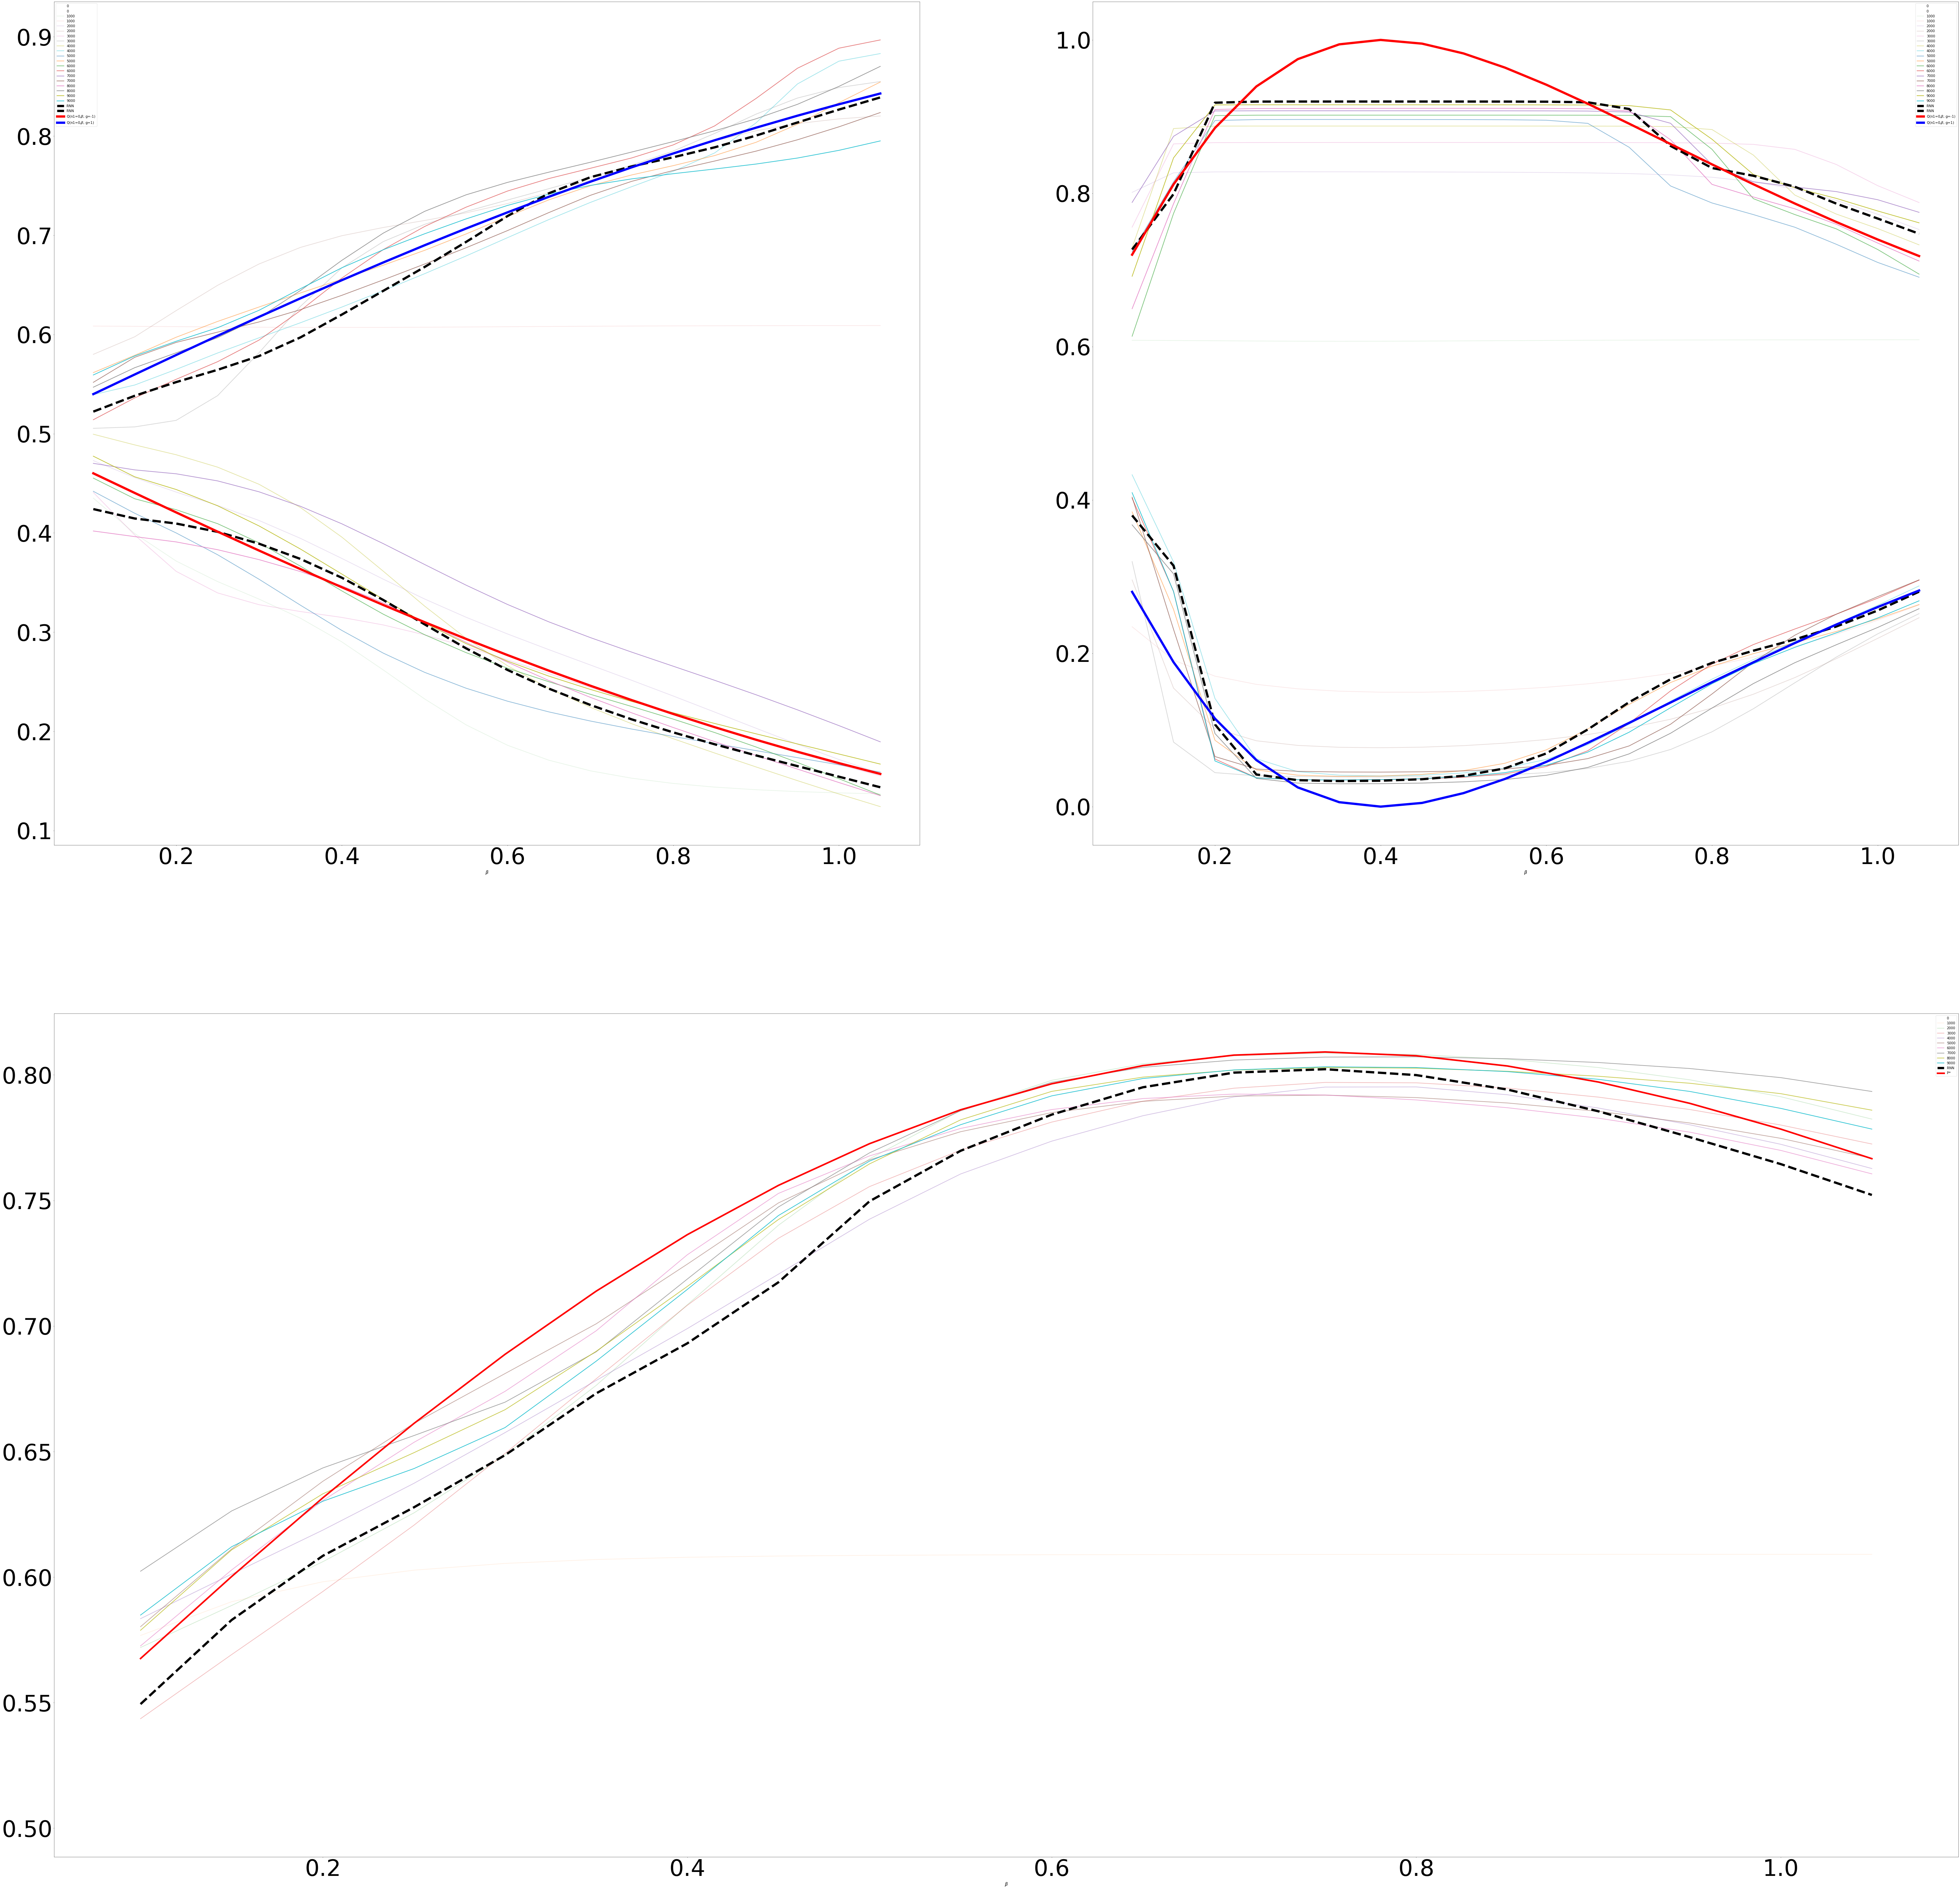

In [14]:
profiles_kennedy(critic, history_predictions)

Ok, now that we've tained the critic pretty well, let's see if the actor learns

In [15]:
actor = Actor(nature="primary", dolinar_layers= 1)
optimizer_actor = tf.keras.optimizers.Adam(lr=0.01)
samples = buffer.sample(128).astype(np.float32)

Let's see how right is this

In [16]:
def critic_grad_tf(critic, experiences):
    unstacked_exp = tf.unstack(tf.convert_to_tensor(experiences), axis=1)
    to_stack = []
    actions_wathed_index = []
    for index in range(0,experiences.shape[-1]-3,2): # I consider from first outcome to last one (but guess)
        actions_wathed_index.append(index)
        to_stack.append(tf.reshape(unstacked_exp[index],(experiences.shape[0],1,1)))

    actions_indexed = tf.concat(to_stack,axis=1)
    
    with tf.GradientTape(persistent = True) as tape:
        tape.watch(actions_indexed)
        
        index_actions=0
        watched_exps=[tf.ones((experiences.shape[0],1,1))*critic.pad_value]
        watched_actions_unstacked = tf.unstack(actions_indexed, axis=1)
        for index in range(0,experiences.shape[-1]-1):
            if index in actions_wathed_index:
                watched_exps.append(tf.expand_dims(watched_actions_unstacked[index_actions], axis=2))
                index_actions+=1
            else:
                watched_exps.append(tf.reshape(unstacked_exp[index],(experiences.shape[0],1,1)))

        qvals = critic(tf.reshape(tf.concat(watched_exps, axis=2), (experiences.shape[0],critic.dolinar_layers+1,2)))
        qvalsunstckd = tf.unstack(qvals, axis=1)
        return [tape.gradient(q, actions_indexed) for q in qvalsunstckd]


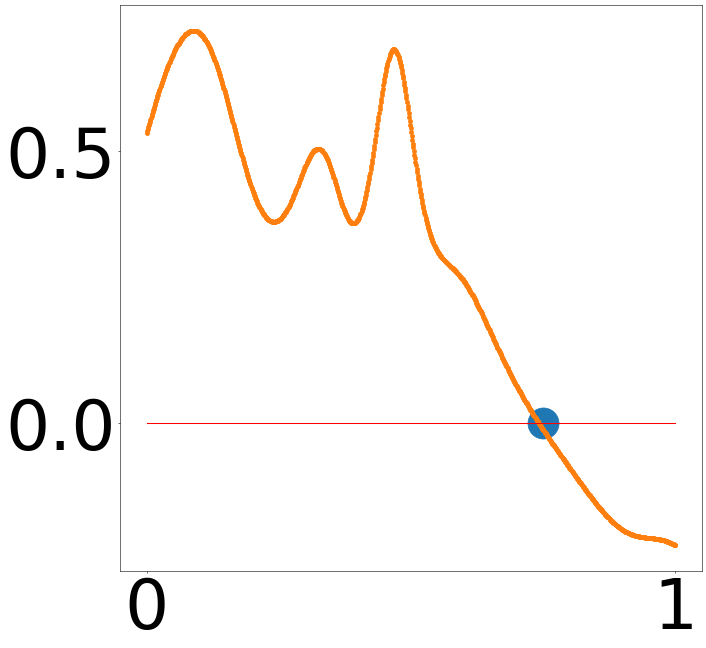

In [27]:
optimal_beta= 0.7499999999999993
samm = np.random.randn(1000,4)
samm[:,0] = np.linspace(0,1,1000)
matplotlib.rc('font', serif='cm10')
plt.rcParams.update({'font.size': 100})
plt.figure(figsize=(15,15), dpi=50)
plt.plot([0,1],[0,0], color="red")
plt.scatter([optimal_beta],[0],s=2000)
plt.scatter(np.linspace(0,1,1000),np.squeeze(critic_grad_tf(critic, samm.astype(np.float32))[0]))

We see it's pretty well in identifying the maximum; Notice we are using sigmoid activation functions; if RELU are used, then discontinuities in the derivative's estimation appear.

Let's train the actor now !

In [33]:
#@tf.function
def actor_grad_tf(actor, dq_da, experiences, optimizer_actor):
    actor.lstm.stateful=False
    actor.reset_states_workaround(int(samples.shape[0]))
    finns = [tf.ones((samples.shape[0], 1,1))*actor.pad_value]
    unstacked_exp = tf.unstack(samples, axis=1)
    for index in range(1,2*actor.dolinar_layers-2,2):
        finns.append(tf.reshape(unstacked_exp[index], (samples.shape[0], 1,1)))
    final_preds = tf.concat(finns, axis=1)
    with tf.GradientTape() as tape:
        tape.watch(actor.trainable_variables)
        final_preds = actor(final_preds)
    dq_da = tf.multiply(dq_da, -1/samples.shape[0])
    da_dtheta=tape.gradient(final_preds, actor.trainable_variables, output_gradients=dq_da)
    optimizer_actor.apply_gradients(zip(da_dtheta, actor.trainable_variables))
    return

In [34]:
actor = Actor(nature="primary", dolinar_layers= 1)
optimizer_actor = tf.keras.optimizers.Adam(lr=0.001)


In [43]:
batch_size=8
beta_would_do=[]
for k in tqdm(range(2*10**2)):
    actor.lstm.stateful=False
    actor.reset_states_workaround(new_batch_size=int(batch_size))
    samples = buffer.sample(batch_size).astype(np.float32)
    dq_da = critic_grad_tf(critic, samples)[0]
    actor_grad_tf(actor, dq_da, experiences, optimizer_actor)
    actor.reset_states_workaround(new_batch_size=1)
    actor.lstm.stateful=True
    context_outcome_actor = np.reshape(np.array([actor.pad_value]),(1,1,1)).astype(np.float32)
    beta_would_do.append(np.squeeze(actor(context_outcome_actor)))

100%|██████████| 200/200 [00:07<00:00, 25.54it/s]


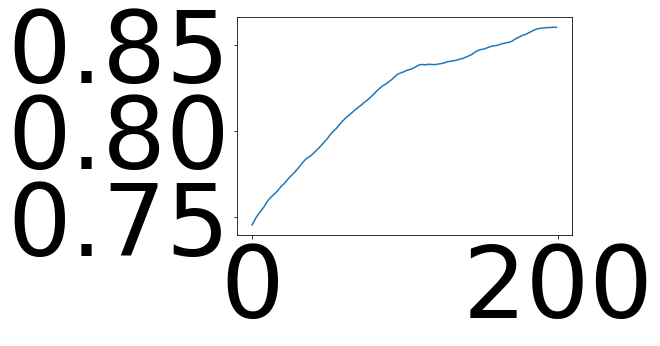

In [44]:
plt.plot(beta_would_do)

In [45]:
beta_would_do[-1]

array(0.86004215, dtype=float32)

In [46]:
experiences = samples
actor.lstm.stateful=False
actor.reset_states_workaround(new_batch_size=int(batch_size))
finns = [tf.ones((samples.shape[0], 1,1))*actor.pad_value]
unstacked_exp = tf.unstack(samples, axis=1)
for index in range(1,2*actor.dolinar_layers-2,2):
    finns.append(tf.reshape(unstacked_exp[index], (samples.shape[0], 1,1)))
inputs_actor = tf.concat(finns, axis=1)
with tf.GradientTape() as tape:
    tape.watch(actor.trainable_variables)
    final_preds = actor(inputs_actor)
dq_da = tf.multiply(dq_da, -1/samples.shape[0])
da_dtheta=tape.gradient(final_preds, actor.trainable_variables, output_gradients=dq_da)
optimizer_actor.apply_gradients(zip(da_dtheta, actor.trainable_variables))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=601>

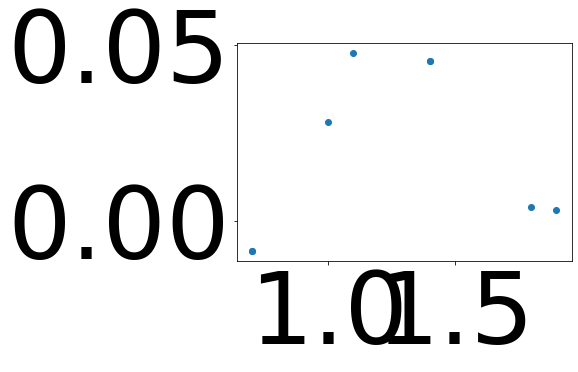

In [48]:
plt.scatter(experiences[:,0],np.squeeze(dq_da))